## Arthar Dataset

Analysis of the citation corpus manually annotated by Awais Athar.

The script will download and unzip the citation sentiment corpus from http://cl.awaisathar.com/citation-sentiment-corpus/.

This dataset contains 8736 sentences taken from different scientific papers. These sentences ares classified as positive (p), negative (n) or neutral (o).

In [2]:
import pandas as pd
import torch

TEST_DATASET_SIZE = 0.4
MODEL_NAME = f'distilbert-base-uncased'
DATA_PATH = f'./data/citation_sentiment_corpus.csv'
SST2_FINETUNED_MODEL_PATH = f'./model/distilbert-base-uncased-finetuned-sst-2-english'
BASE_MODEL_PATH = f'./model/distilbert-base-uncased'

rawdata_df = pd.read_csv(DATA_PATH)
rawdata_df['Sentiment'] = rawdata_df['Sentiment'].map({'o': 0, 'p': 1, 'n': 2})
rawdata_df['Sentence_Length'] = rawdata_df['Citation_Text'].str.len()
rawdata_df = rawdata_df[rawdata_df['Sentence_Length'] <= 1000]
print(rawdata_df.shape)

(8699, 5)


## 使用Trainer类微调Citation的情感分析

In [3]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoModel
from transformers import DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import torch

# 分割数据集：训练集80%，验证集10%，测试集10%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    rawdata_df['Citation_Text'].tolist(), rawdata_df['Sentiment'].tolist(), test_size=TEST_DATASET_SIZE, stratify=rawdata_df['Sentiment'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [4]:
# 分词器
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
# padding代表填充批量样本最长的长度 attention_mask代表哪些是padding的，此时模型就忽略输入的填充部分
tokenized_datasets = emotion_dataset.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, max_length=512),
                                      batch_size=None, batched=True) # WordPiece分词器
print(tokenized_datasets['train'].column_names) # 这里面有文本的名字
pd.DataFrame(tokenized_datasets['validation']).head()

Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


,text,label,input_ids,attention_mask
0,We found that the deletion of lead parts did n...,0,"[101, 2057, 2179, 2008, 1996, 3972, 20624, 223...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Brown et al. 1993).,0,"[101, 2829, 3802, 2632, 1012, 2857, 1007, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
2,1 Introduction Bilingual word alignment is fir...,0,"[101, 1015, 4955, 17636, 2773, 12139, 2003, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,In the hierarchical phrase-based model (Chiang...,1,"[101, 1999, 1996, 25835, 7655, 1011, 2241, 294...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,These rules are learned using a word alignment...,0,"[101, 2122, 3513, 2024, 4342, 2478, 1037, 2773...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
from huggingface_hub import notebook_login
import wandb
import os

# 加载DistilBERT模型
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}
model = AutoModel.from_pretrained(SST2_FINETUNED_MODEL_PATH).to(device)

In [7]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)
print(outputs.last_hidden_state.size()) # [batch_size x seq_len x hidden_size]

Input tensor shape: torch.Size([1, 6])
BaseModelOutput(last_hidden_state=tensor([[[-0.1373,  0.4041, -0.3265,  ..., -0.3719, -0.2364,  0.5102],
         [ 0.0267,  0.0839, -0.2512,  ..., -0.5915, -0.2525,  0.6035],
         [-0.1104,  0.3257, -0.0721,  ..., -0.3377, -0.0184,  0.8107],
         [ 0.1425,  0.4043,  0.0904,  ..., -0.2084, -0.1147,  0.7108],
         [ 0.0886,  0.3949, -0.3105,  ..., -0.4448,  0.0462,  0.0756],
         [ 0.4265,  0.3764,  0.1562,  ...,  0.0759, -0.4572,  0.1399]]],
       device='cuda:0'), hidden_states=None, attentions=None)
torch.Size([1, 6, 768])


In [8]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [10]:
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = tokenized_datasets.map(extract_hidden_states, batched=True, batch_size=16)

Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

In [11]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [12]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((5219, 768), (1740, 768))

## UMAP可视化用六边形箱图

In [13]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,10.737819,5.464501,0
1,9.272755,3.835736,0
2,3.538056,7.462159,0
3,0.093633,7.221502,2
4,9.504342,5.494489,0


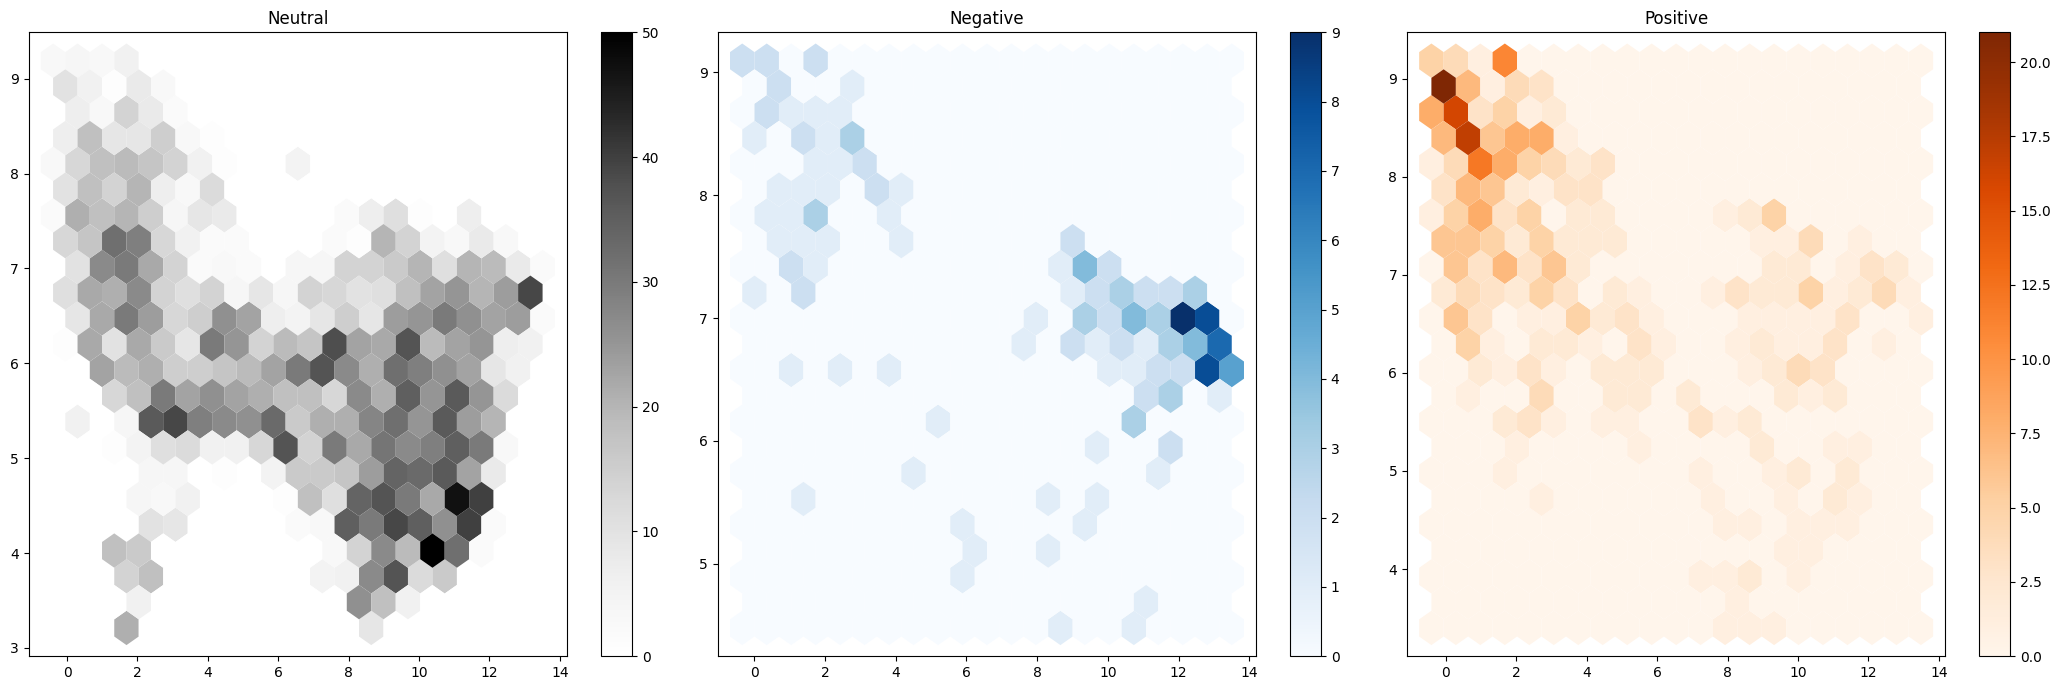

In [14]:
import matplotlib.pyplot as plt

labels = df_emb['label'].unique()
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
cmaps = ["Greys", "Blues", "Oranges"]

for i, label in enumerate(labels):
    # 筛选出当前标签的数据
    subset = df_emb[df_emb['label'] == label]
    
    # 在对应的子图中绘制hexbin图
    ax = axes[i]
    hb = ax.hexbin(subset['X'], subset['Y'], gridsize=20, cmap=cmaps[i], linewidths=(0,))
    fig.colorbar(hb, ax=ax)
    axes[i].set_title(f'{id2label[label]}')

plt.tight_layout()
plt.show()

In [15]:
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8591954022988506

In [16]:

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.8724137931034482

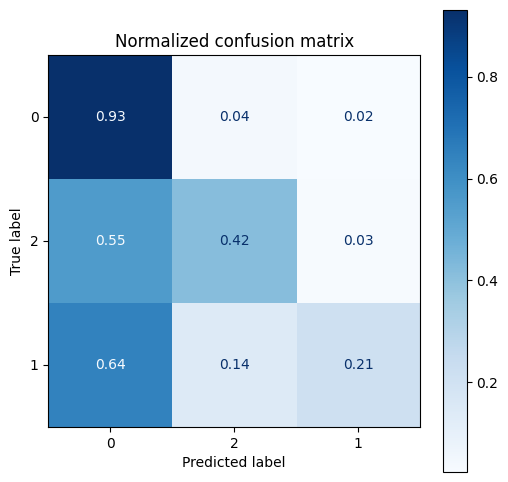

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix_normalized(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix_normalized(y_preds, y_valid, labels)